<div style="border:solid steelblue 1px; padding: 20px">
    
<font size="4"><p style="text-align:center"><b>Отток клиентов 🏦</b></p></font>

</div>

# Содержание
1. [Описание данных](#Описание_данных)
2. [EDA](#EDA)
3. [Исследование задачи](#Исследование_задачи) 
4. [Борьба с дисбалансом](#Борьба_с_дисбалансом) 
5. [Взвешивание классов](#Взвешивание_классов) 
5. [Увеличение выборки](#Увеличение_выборки) 
5. [Уменьшение выборки](#Уменьшение_выборки) 
6. [Тестирование модели](#Тестирование_модели) 
7. [Вывод](#Вывод)

<div class="alert alert-info">
<font size="4", color = "black"><a name="Описание_данных"><h3>Описание данных</h3></a></font>
    <br /> 
    <font size="3", color = "black">

<div class="alert alert-info">
<font size="4", color = "black">📌 Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Были предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 


<ul>
 <li>RowNumber — индекс строки в данных</li>
 <li>CustomerId — уникальный идентификатор клиента</li>
 <li>Surname — фамилия</li>
 <li>CreditScore — кредитный рейтинг</li>
 <li>Geography — страна проживания</li>
 <li>Gender — пол</li>
 <li>Age — возраст</li>
 <li>Tenure — сколько лет человек является клиентом банка</li>
 <li>Balance — баланс на счёте</li>
 <li>NumOfProducts — количество продуктов банка, используемых клиентом</li>
 <li>HasCrCard — наличие кредитной карты</li>
 <li>IsActiveMember — активность клиента</li>
 <li>EstimatedSalary — предполагаемая зарплата</li>
</ul>

<div class="alert alert-info">
<font size="4", color = "black"><a name="EDA"><h3>EDA</h3></a></font>
    <br /> 
    <font size="3", color = "black">

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tqdm import tqdm

In [2]:
pth1 = '/datasets/Churn.csv'
pth2 = 'Churn.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
   print('Something is wrong')


In [3]:
data.head()

In [4]:
data.info()

In [5]:
#проверяем если ли дубликаты
data.duplicated().sum()

In [6]:
#удалим столбцы, которые не нужны при исследовании и заполним столбец Tenure
data = data.drop(['RowNumber' , 'CustomerId', 'Surname'], axis=1)
data.Tenure = data.Tenure.fillna(0)
data

<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Вывод</b></font>
    <br /> 
    <font size="3", color = "black">
<br />В данных дубликатов не обнаружено. Были удалены данные столбцов 'RowNumber' , 'CustomerId' и 'Surname'не влияющие на построение модели. В стобце 'Tenure' nan заполнены 0, т.к. возможно клиент только стал клиентом банка. Применено прямое кодирование ко всему датафрейму, чтобы избежать дамми-ловушку.

<div class="alert alert-info">
<font size="4", color = "black"><a name="Исследование_задачи"><h3>Исследование задачи</h3></a></font>
    <br /> 
    <font size="3", color = "black">

In [7]:
features = data.drop(['Exited'], axis=1)
target = data.Exited 

In [8]:
#разобьем данные на выборки
features_train, X, target_train, y = train_test_split(features, target, 
                                                      train_size = 0.4, 
                                                      random_state=42,
                                                      stratify=target) 
features_valid, features_test, target_valid, target_test = train_test_split(X, y, 
                                                                            train_size = 0.5,
                                                                            random_state=42,
                                                                            stratify=y)
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

In [9]:
features_train = pd.get_dummies(features_train, drop_first=True)
features_valid = pd.get_dummies(features_valid, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

In [10]:
#Масштабирование признаков
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [11]:
# Оценивание эффективности выполнения алгоритма случайного леса 
best_model_rf = None
accuracy_RandomForest = 0
best_est = 0
best_depth = 0
for est in tqdm(range(10, 81, 10)):
    for depth in range (1, 51):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result_rf = accuracy_score(target_valid, predicted_valid) 
        if result_rf > accuracy_RandomForest:
            best_model_rf = model
            accuracy_RandomForest = result_rf
            best_est = est
            best_depth = depth

print("Accuracy наилучшей модели на валидационной выборке:", accuracy_RandomForest, '\n'
      "Количество деревьев:", best_est,'\n' "Максимальная глубина:", best_depth)

In [12]:
# Оценивание эффективности выполнения алгоритма дерева решений
best_model_dt = None
accuracy_DecisionTree = 0
best_depths = 0
for depths in tqdm(range (1, 101)):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depths) 
    model.fit(features_train, target_train) 
    predicted_valid = model.predict(features_valid) 
    result_dt = accuracy_score(target_valid, predicted_valid) 
    if result_dt > accuracy_DecisionTree:
        best_model_dt = model
        accuracy_DecisionTree = result_dt
        best_depths = depths
print("Accuracy лучшей модели:", accuracy_DecisionTree, '\n'"Максимальная глубина:", best_depths)

In [13]:
%%time
# Оценивание эффективности выполнения алгоритма логистической регрессии 
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
accuracy_LogisticRegression = accuracy_score(target_valid, predicted_valid) 
print("Accuracy модели на валидационной выборке:", accuracy_LogisticRegression)

In [14]:
# Проверка адекватности модели
target_pred_constant = pd.Series ([0] * len(target_valid))
accuracy_const_model = accuracy_score(target_valid, target_pred_constant)
print("Accuracy константной модели:", accuracy_const_model)

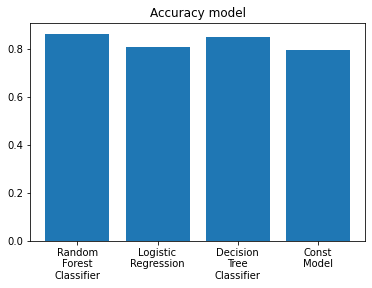

In [15]:
name_model = ['Random''\n''Forest''\n''Classifier','Logistic''\n''Regression','Decision''\n''Tree''\n''Classifier', 'Const''\n''Model']
estimation_accuracy = [accuracy_RandomForest, accuracy_LogisticRegression, accuracy_DecisionTree, accuracy_const_model]
plt.bar(x=name_model, height=estimation_accuracy)
plt.title("Accuracy model");

 <div class="alert alert-info">
    <font size="3", color = "black"><b>✍ Комментарий студента</b></font>
  <br><font size="3", color = "black">
    <br>
Из графика видно, что модели Logistic Regression, Random Forest Classifier и Decision Tree Classifier показывают результаты лучше, чем константная модель — модели можно считать адекватными. 

In [16]:
#посчитаем метрики моделей 
model = RandomForestClassifier(random_state=12345, n_estimators=best_est, max_depth=best_depth)  # обучите модель с заданной глубиной дерева
model.fit(features_train, target_train) # обучите модель
predicted_valid = model.predict(features_valid) # получите предсказания модели
precision_disbalanced_RF = precision_score(target_valid, predicted_valid)
recall_disbalanced_RF = recall_score(target_valid, predicted_valid)
f1_disbalanced_RF = f1_score(target_valid, predicted_valid)
print('Precision RandomForestClassifier:', precision_disbalanced_RF)
print('Recall RandomForestClassifier:', recall_disbalanced_RF)
print("F1 - мера RandomForestClassifier:", f1_disbalanced_RF)
print()


model = DecisionTreeClassifier(random_state=12345, max_depth=best_depths) # обучите модель с заданной глубиной дерева
model.fit(features_train, target_train) # обучите модель
predicted_valid = model.predict(features_valid) # получите предсказания модели
precision_disbalanced_DT = precision_score(target_valid, predicted_valid)
recall_disbalanced_DT = recall_score(target_valid, predicted_valid)
f1_disbalanced_DT = f1_score(target_valid, predicted_valid)
print('Precision DecisionTreeClassifier:', precision_disbalanced_DT)
print('Recall DecisionTreeClassifier:', recall_disbalanced_DT)
print("F1 - мера DecisionTreeClassifier:", f1_disbalanced_DT)
print()


model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
precision_disbalanced_LR = precision_score(target_valid, predicted_valid)
recall_disbalanced_LR = recall_score(target_valid, predicted_valid)
f1_disbalanced_LR= f1_score(target_valid, predicted_valid)
print('Precision LogisticRegression:', precision_disbalanced_LR)
print('Recall LogisticRegression:', recall_disbalanced_LR)
print("F1 - мера LogisticRegression:", f1_disbalanced_LR)
print()

 <div class="alert alert-info">
    <font size="3", color = "black"><b>✍ Комментарий студента</b></font>
  <br><font size="3", color = "black">
    <br>
У алгоритма LogisticRegression самый худший показатель f1 меры.

 <div class="alert alert-info">
    <font size="3", color = "black"><b>✍ Вывод</b></font>
  <br><font size="3", color = "black">
    <br>
Исходя из вышеизложенного, в дальнейшем исследовании будем применять алгоритмы Random Forest Classifier и Decision Tree Classifier.

<div class="alert alert-info">
<font size="4", color = "black"><a name="Борьба_с_дисбалансом"><h3>Борьба с дисбалансом</h3></a></font>
    <br /> 
    <font size="3", color = "black">

 <div class="alert alert-info">
    <font size="3", color = "black"><b>✍ Комментарий студента</b></font>
  <br><font size="3", color = "black">
    <br>
Чтобы увеличить качество модели при дисбалансе классов применим техники: взвешивание классов, upsampling и downsampling.

<div class="alert alert-info">
<font size="4", color = "black"><a name="Взвешивание_классов"><h4>Взвешивание классов</h4></a></font>
    <br /> 
    <font size="3", color = "black">

In [17]:
model = DecisionTreeClassifier(random_state=12345, max_depth=best_depths, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
precision_weight_DT = precision_score(target_valid, predicted_valid)
recall_weight_DT = recall_score(target_valid, predicted_valid)
f1_weight_DT = f1_score(target_valid, predicted_valid)
print('Алгоритм Решающее дерево')
print('Точность попадания по классам:', accuracy_score(target_valid, predicted_valid))
print('Precision DecisionTreeClassifier:', precision_weight_DT)
print('Recall DecisionTreeClassifier:', recall_weight_DT)
print('F1 - мера DecisionTreeClassifier:', f1_weight_DT)

In [18]:
model = RandomForestClassifier(random_state=12345, n_estimators=best_est, max_depth=best_depth, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
precision_weight_RF = precision_score(target_valid, predicted_valid)
recall_weight_RF = recall_score(target_valid, predicted_valid)
f1_weight_RF = f1_score(target_valid, predicted_valid)
print('Алгоритм Случайный лес')
print('Точность попадания по классам:', accuracy_score(target_valid, predicted_valid))
print('Precision DecisionTreeClassifier:', precision_weight_RF)
print('Recall DecisionTreeClassifier:', recall_weight_RF)
print('F1 - мера RandomForestClassifier:', f1_weight_RF)

 <div class="alert alert-info">
    <font size="3", color = "black"><b>✍ Комментарий студента</b></font>
  <br><font size="3", color = "black">
    <br>
У алгоритма RandomForestClassifier со взвешенными весами классов - лучший показатель f1 меры.

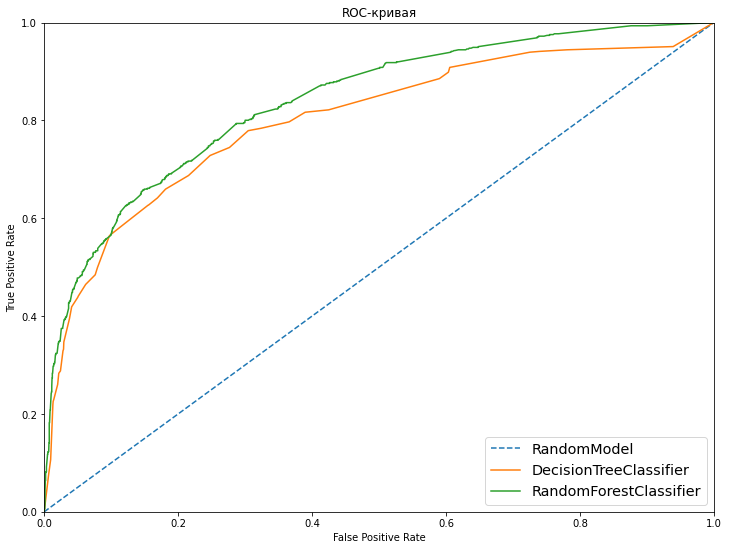

In [19]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = DecisionTreeClassifier(random_state=12345, max_depth=best_depths, class_weight='balanced')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

model = RandomForestClassifier(random_state=12345, n_estimators=best_est, max_depth=best_depth, class_weight='balanced')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()


 <div class="alert alert-info">
    <font size="3", color = "black"><b>✍ Комментарий студента</b></font>
  <br><font size="3", color = "black">
    <br>
При оценке моделей по AUT ROC, лучший результат показал  - алгоритм RandomForestClassifier со взвешенными весами классов.

<div class="alert alert-info">
<font size="4", color = "black"><a name="Увеличение_выборки"><h4>Увеличение выборки</h4></a></font>
    <br /> 
    <font size="3", color = "black">

In [20]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4) # нужно увеличить в 4 раза

print(target_upsampled.value_counts())

In [21]:
model = DecisionTreeClassifier(random_state=12345, max_depth=best_depths)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
precision_upsampled_DT = precision_score(target_valid, predicted_valid)
recall_upsampled_DT = recall_score(target_valid, predicted_valid)
f1_upsampled_DT = f1_score(target_valid, predicted_valid)
print('Алгоритм Решающее дерево')
print('Точность попадания по классам:', accuracy_score(target_valid, predicted_valid))
print('Precision DecisionTreeClassifier:', precision_upsampled_DT)
print('Recall DecisionTreeClassifier:', recall_upsampled_DT)
print('F1 DecisionTreeClassifier:', f1_upsampled_DT)

In [22]:
model = RandomForestClassifier(random_state=12345, n_estimators=best_est, max_depth = best_depth)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
precision_upsampled_RF = precision_score(target_valid, predicted_valid)
recall_upsampled_RF = recall_score(target_valid, predicted_valid)
f1_upsampled_RF = f1_score(target_valid, predicted_valid)
print('Алгоритм Случайный лес')
print('Точность попадания по классам:', accuracy_score(target_valid, predicted_valid)) 
print('Precision DecisionTreeClassifier:', precision_upsampled_RF)
print('Recall DecisionTreeClassifier:', recall_upsampled_RF)
print('F1 RandomForestClassifier:', f1_upsampled_RF)

 <div class="alert alert-info">
    <font size="3", color = "black"><b>✍ Комментарий студента</b></font>
  <br><font size="3", color = "black">
    <br>
У алгоритма DecisionTreeClassifier с увеличенной выборкой - лучший показатель f1 меры. Он равен 0.45, однако это значение меньше показателя f1 меры RandomForestClassifier со взвешенными весами классов.  

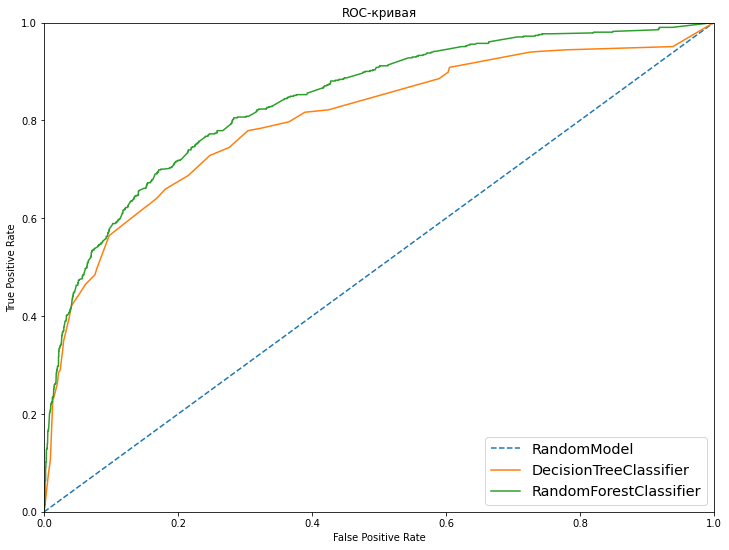

In [23]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = DecisionTreeClassifier(random_state=12345, max_depth=best_depths)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

model = RandomForestClassifier(random_state=12345, n_estimators=best_est, max_depth=best_depth)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая");


 <div class="alert alert-info">
    <font size="3", color = "black"><b>✍ Комментарий студента</b></font>
  <br><font size="3", color = "black">
    <br>
Также как и при технике взвешанных классов, лучший (и почти одинаковый) результат показал  - алгоритм RandomForestClassifier.

<div class="alert alert-info">
<font size="4", color = "black"><a name="Уменьшение_выборки"><h4>Уменьшение выборки</h4></a></font>
    <br /> 
    <font size="3", color = "black">

In [24]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(target_downsampled.value_counts())

In [25]:
model = DecisionTreeClassifier(random_state=12345, max_depth=best_depths)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
precision_downsampled_DT = precision_score(target_valid, predicted_valid)
recall_downsampled_DT = recall_score(target_valid, predicted_valid)
f1_downsampled_DT = f1_score(target_valid, predicted_valid)
print('Алгоритм Решающее дерево')
print('Точность попадания по классам:', accuracy_score(target_valid, predicted_valid))
print('Precision DecisionTreeClassifier:', precision_downsampled_DT)
print('Recall DecisionTreeClassifier:', recall_downsampled_DT)
print('F1 DecisionTreeClassifier:', f1_downsampled_DT)
print()

In [26]:
model = RandomForestClassifier(random_state=12345, n_estimators=best_est,max_depth=best_depth)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
precision_downsampled_RF = precision_score(target_valid, predicted_valid)
recall_downsampled_RF = recall_score(target_valid, predicted_valid)
f1_downsampled_RF = f1_score(target_valid, predicted_valid)
print('Алгоритм Случайный лес')
print('Точность попадания по классам:', accuracy_score(target_valid, predicted_valid))
print('Precision DecisionTreeClassifier:', precision_downsampled_RF)
print('Recall DecisionTreeClassifier:', recall_downsampled_RF)
print('F1 RandomForestClassifier:', f1_downsampled_RF)
print()

 <div class="alert alert-info">
    <font size="3", color = "black"><b>✍ Комментарий студента</b></font>
  <br><font size="3", color = "black">
    <br>
У алгоритма RandomForestClassifier с уменьшенной выборкой - лучший показатель f1 меры. Он равен 0.57, однако это значение меньше показателя f1 меры RandomForestClassifier со взвешенными весами классов, которое равняется 0.5958.  

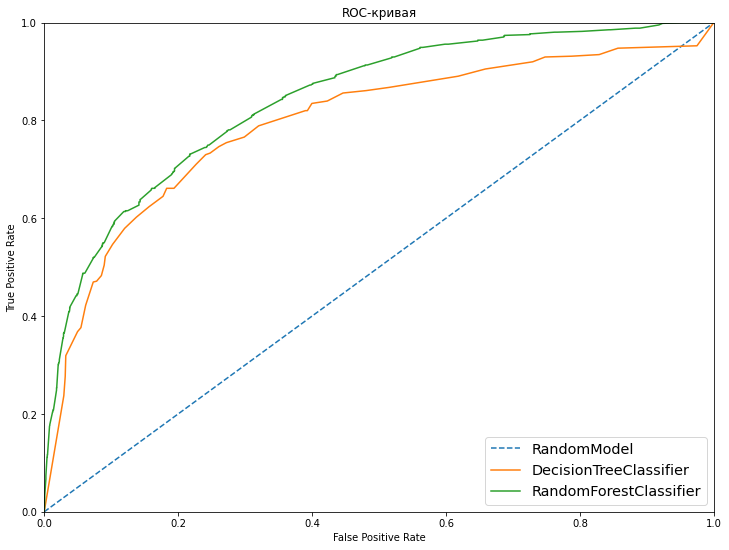

In [27]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = DecisionTreeClassifier(random_state=12345, max_depth=best_depths)
model.fit(features_downsampled, target_downsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

model = RandomForestClassifier(random_state=12345, n_estimators=best_est, max_depth=best_depth)
model.fit(features_downsampled, target_downsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')


plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

 <div class="alert alert-info">
    <font size="3", color = "black"><b>✍ Комментарий студента</b></font>
  <br><font size="3", color = "black">
    <br>
При расчете показателя AUT ROC лучший результат показал  - алгоритм RandomForestClassifier.

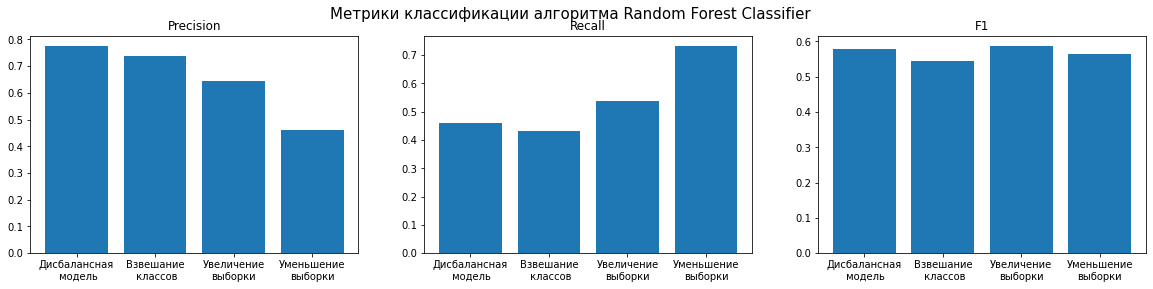

In [28]:
#сравнение метрик Random Forest Classifier несбалансированной модели с техниками
# взвешивания классов, upsampling и downsampling для улучшения метрик качества
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Метрики классификации алгоритма Random Forest Classifier', fontsize=15);
name_model = ['Дисбалансная' '\n' ' модель',
              'Взвешание' '\n' ' классов',
              'Увеличение' '\n' 'выборки',
              'Уменьшение' '\n' 'выборки']
estimation_precision = [precision_disbalanced_RF,
                        precision_weight_RF,
                        precision_upsampled_RF,
                        precision_downsampled_RF]
estimation_recall = [recall_disbalanced_RF,
                     recall_weight_RF,
                     recall_upsampled_RF,
                     recall_downsampled_RF]
estimation_f1 = [f1_disbalanced_RF,
                 f1_weight_RF,
                 f1_upsampled_RF,
                 f1_downsampled_RF]
axes[0].bar(name_model, estimation_precision)
axes[0].set_title("Precision")
axes[1].bar(name_model, estimation_recall)
axes[1].set_title("Recall")
axes[2].bar(name_model, estimation_f1)
axes[2].set_title("F1");



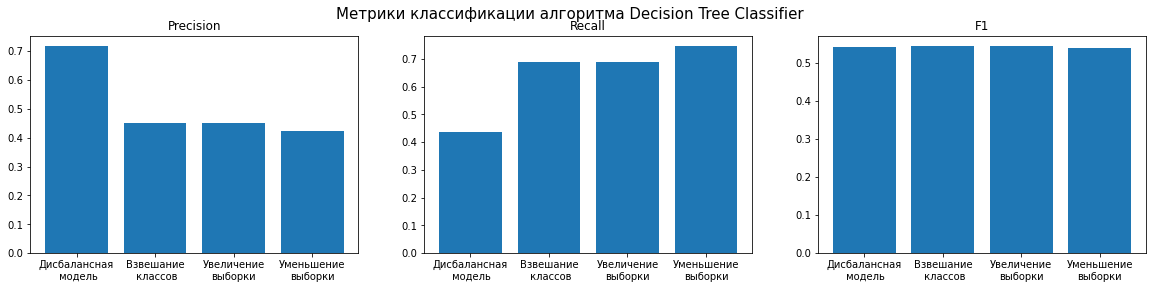

In [29]:
#сравнение метрик меры Decision Tree Classifier несбалансированной модели с техниками
# взвешивания классов, upsampling и downsampling для улучшения метрик качества
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Метрики классификации алгоритма Decision Tree Classifier', fontsize=15);
name_model = ['Дисбалансная' '\n' ' модель',
              'Взвешание' '\n' ' классов',
              'Увеличение' '\n' 'выборки',
              'Уменьшение' '\n' 'выборки']
estimation_precision = [precision_disbalanced_DT,
                        precision_weight_DT,
                        precision_upsampled_DT,
                        precision_downsampled_DT]
estimation_recall = [recall_disbalanced_DT,
                     recall_weight_DT,
                     recall_upsampled_DT,
                     recall_downsampled_DT]
estimation_f1 = [f1_disbalanced_DT,
                 f1_weight_DT,
                 f1_upsampled_DT,
                 f1_downsampled_DT]
axes[0].bar(name_model, estimation_precision)
axes[0].set_title("Precision")
axes[1].bar(name_model, estimation_recall)
axes[1].set_title("Recall")
axes[2].bar(name_model, estimation_f1)
axes[2].set_title("F1");

 <div class="alert alert-info">
    <font size="3", color = "black"><b>✍ Комментарий студента</b></font>
  <br><font size="3", color = "black">
    <br>
Лучшим решением стало взвешивания классов в алгоритме Random Forest Classifier по показателю F1 меры. Precision, при использовании техник взвешивания классов, upsampling и downsampling для дисбалансной модели, снижается, а метрика recall наоборот повышается. 

 <div class="alert alert-info">
    <font size="3", color = "black"><b>✍ Вывод</b></font>
  <br><font size="3", color = "black">
    <br>
В результате исследования получена лучшая модель с лучшими показателями как по F1-мере, так и по AUC-ROC - <b> 🌳 Случайный лес с увеличенной выборкой.</b>

<div class="alert alert-info">
<font size="4", color = "black"><a name="Тестирование_модели"><h3>Тестирование модели</h3></a></font>
    <br /> 
    <font size="3", color = "black">

 <div class="alert alert-info">
    <font size="3", color = "black"><b>✍ Комментарий студента</b></font>
  <br><font size="3", color = "black">
    <br> К тестовой выборке применем алгоритм Random Forest Classifier с увеличенной выборкой. 

In [30]:
model = RandomForestClassifier(random_state=12345, n_estimators=best_est, max_depth = best_depth)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
print('Модель случайного леса с увеличенной выборкой')
print('Точность попадания по классам:', accuracy_score(target_test, predicted_test)) 
print('F1:', f1_score(target_test, predicted_test))
print()

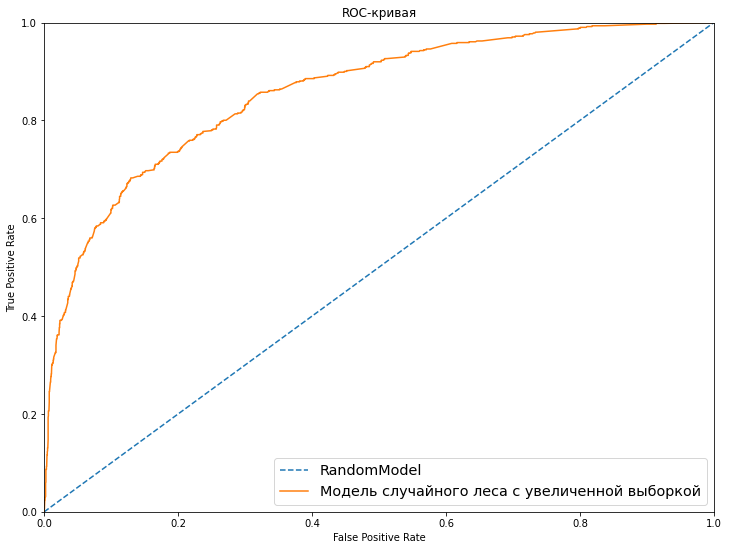

In [31]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')

model = RandomForestClassifier(random_state=12345,
                               n_estimators=best_est,
                               max_depth = best_depth)
model.fit(features_upsampled, target_upsampled)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC Модель случайного леса с увеличенной выборкой:',auc_roc)
plt.plot(fpr, tpr, label='Модель случайного леса с увеличенной выборкой')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

<div class="alert alert-info">
<font size="4", color = "black"><a name="Вывод"><h3>Вывод</h3></a></font>
    <br /> 
    <font size="3", color = "black">

 <div class="alert alert-info">
    <font size="3", color = "black">
<br>Было проведено исследование, чтобы построить модель,<b> уйдёт клиент из банка «Бета-Банка» в ближайшее время или нет</b>, с предельно большим значением F1 меры. 
        
        
<br><b> Входные данные </b> - исторические данные о поведении клиентов и расторжении договоров с банком.
        
        
<br>Были обучены модели логистической регрессии, дерева решений и случайного леса. 
        <br><b>Какая модель лучше?</b>
<br>У каждой — свои достоинства и недостатки. 
<br>У алгоритма классификации - случайный лес, высокое качество (accuracy), но медленная скорость.
<br>У дерева решений, качество (accuracy) ниже, чем у случайного леса, но высокая скорость работы.
<br>У логистической регресии самое низкое качество (accuracy), но высокая скорость работы.
        
<br><b> Про проверки моделей на адекватность в сравнении с контантной моделью, худший результат показала логистическая регресия.</b>
        
<br> Для улучшения метрик качества моделей применены техники взвешивания классов, upsampling и downsampling. После их применения была найдена лучшая модель RandomForestClassifier с увеличенной выборкой. 
        
<br><b> Финальные параметры выбранной модели RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=17).</b>
 
<br><b>Проведена проверка финальной модели тестовой выборкой. </b>
